In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas_ta as ta
import datetime
from logzero import logger, loglevel
import logzero
import st2

In [2]:
data = pd.read_csv('../FnO/5M/ADANIENT.csv')

In [3]:
data.Datetime = pd.to_datetime(data.Datetime)
data.set_index('Datetime', inplace=True)

In [4]:
data_hourly = st2.custom_resample(data,freq='1h')

In [5]:
data_hourly['RSI'] = ta.rsi(data_hourly['Close'], timeperiod=14)


In [6]:
data['Date'] = data.index.date

In [7]:
data['datetime'] = data.index

In [8]:
data_hourly

,Open,High,Low,Close,Volume,RSI
Datetime,,,,,,
2020-07-10 09:15:00,161.50,163.40,160.55,161.00,493355,NaN
2020-07-10 10:15:00,161.00,161.00,158.50,158.95,372247,NaN
2020-07-10 11:15:00,158.90,160.15,158.60,159.90,340684,NaN
2020-07-10 12:15:00,159.90,160.40,158.85,159.90,205624,NaN
2020-07-10 13:15:00,159.80,160.50,159.10,159.40,118948,NaN
...,...,...,...,...,...,...
2024-08-16 11:15:00,3044.10,3055.95,3042.45,3051.15,51345,39.391420
2024-08-16 12:15:00,3051.00,3081.35,3050.15,3080.35,118929,47.846981
2024-08-16 13:15:00,3081.35,3121.60,3072.00,3117.00,249451,56.121390


In [9]:
merged_Data = pd.merge(data, data_hourly[['RSI']], left_index=True, right_index=True, how='left').ffill()

In [10]:
daily_data = st2.custom_resample(data, freq = 'D')
daily_data['Date'] = daily_data.index.date
daily_data = st2.apply_pivots(daily_data)


In [11]:
daily_data

,Open,High,Low,Close,Volume,Date,Prev_High,Prev_Low,Prev_Close,PP,TC,BC,R1,R2,R3,S1,S2,S3,%CPR
Datetime,,,,,,,,,,,,,,,,,,,
2020-07-10 00:15:00,161.50,163.40,158.50,159.70,1943383,2020-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-13 00:15:00,161.45,162.45,154.35,156.05,2582045,2020-07-13,163.40,158.50,159.70,160.533333,161.966667,159.516667,162.566667,165.433333,167.466667,157.666667,155.633333,152.766667,0.015262
2020-07-14 00:15:00,155.90,156.25,149.00,149.75,2350001,2020-07-14,162.45,154.35,156.05,157.616667,160.033333,155.983333,160.883333,165.716667,168.983333,152.783333,149.516667,144.683333,0.025695
2020-07-15 00:15:00,150.10,153.85,147.00,147.75,2176722,2020-07-15,156.25,149.00,149.75,151.666667,153.958333,150.333333,154.333333,158.916667,161.583333,147.083333,144.416667,139.833333,0.023901
2020-07-16 00:15:00,148.10,150.00,145.20,148.90,1472461,2020-07-16,153.85,147.00,147.75,149.533333,151.691667,148.266667,152.066667,156.383333,158.916667,145.216667,142.683333,138.366667,0.022905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09 00:15:00,3209.00,3219.30,3171.05,3186.50,757154,2024-08-09,3242.65,3156.55,3172.55,3190.583333,3216.616667,3173.566667,3224.616667,3276.683333,3310.716667,3138.516667,3104.483333,3052.416667,0.013493
2024-08-12 00:15:00,3100.00,3169.85,3014.00,3140.90,10151900,2024-08-12,3219.30,3171.05,3186.50,3192.283333,3205.791667,3181.666667,3213.516667,3240.533333,3261.766667,3165.266667,3144.033333,3117.016667,0.007557
2024-08-13 00:15:00,3170.00,3178.10,3081.75,3085.70,2181789,2024-08-13,3169.85,3014.00,3140.90,3108.250000,3139.050000,3061.125000,3202.500000,3264.100000,3358.350000,3046.650000,2952.400000,2890.800000,0.025070


In [12]:
merged_Data = pd.merge(merged_Data, daily_data[['Date', 'PP', 'TC', 'BC', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3', '%CPR']], left_on='Date', right_on='Date', how='left')

In [13]:
merged_Data.set_index('datetime', inplace=True)


In [14]:
merged_Data['wma'] = ta.vwma(merged_Data['Close'], merged_Data['Volume'], length=5)

In [15]:
# def define_trading_conditions(data):
#     """Define the buy and sell conditions."""
#     start_time = datetime.time(10, 14)
#     end_time = datetime.time(14, 16)
#     buy_condition = (
#         (data['%CPR'] < 0.01) &
#         (data.RSI > 70) &
#         (data.Close > data.R1) &
#         (data.Close.shift(1) < data.R1) &
#         (data.index.time >= start_time) &
#         (data.index.time <= end_time)
#     )
                    
#     sell_condition = (data.Close > data.R3) | (data.Close < data.TC) 
    
#     data['Signal'] = np.select([buy_condition, sell_condition], ['Buy', 'Sell'])
#     data['Shifted_close'] = data['Close'].shift()
    
    
#     return data

In [16]:
# def define_trading_conditions(data):
#     """Define the buy and sell conditions."""
#     start_time = datetime.time(10, 14)
#     end_time = datetime.time(14, 16)
#     buy_condition = (
#         (data['%CPR'] < 0.01) &
#         (data.RSI > 70) &
#         (data.Close > data.R1) &
#         (data.Close.shift(1) < data.R1) &
#         (data.index.time >= start_time) &
#         (data.index.time <= end_time)
#     )
                    
#     sell_condition = (data.Close > data.R3) | (data.Close < data.TC) | (data.RSI < 50)
#     short_condition = (
#         (data['%CPR'] < 0.01) &
#         (data.RSI < 30) &
#         (data.Close < data.S1) &
#         (data.Close.shift(1) > data.S1) &
#         (data.index.time >= start_time) &
#         (data.index.time <= end_time)
#     )
    
#     cover_condition  = (data.Close < data.S3) | (data.Close > data.BC) | (data.RSI > 50)
    
#     data['Signal'] = np.select([buy_condition, sell_condition,short_condition,cover_condition], ['Buy', 'Sell','Short','Cover'])
#     data['Shifted_close'] = data['Close'].shift()
    
#     return data

In [17]:
def define_trading_conditions(data):
    """Define the buy and sell conditions."""
    start_time = datetime.time(10, 14)
    end_time = datetime.time(14, 16)
    buy_condition = (
        (data['%CPR'] < 0.01) &
        (data.RSI > 70) &
        (data.Close > data.R1) &
        (data.Close.shift(1) < data.R1) &
        (data.index.time >= start_time) &
        (data.index.time <= end_time)
    )
                    
    sell_condition = (data.Close > data.R3) | (data.Close < data.TC) | (data.RSI < 50)
    short_condition = (
        (data['%CPR'] < 0.01) &
        (data.RSI < 30) &
        (data.Close < data.S1) &
        (data.Close.shift(1) > data.S1) &
        (data.index.time >= start_time) &
        (data.index.time <= end_time)
    )
    
    cover_condition  = (data.Close < data.S3) | (data.Close > data.BC) | (data.RSI > 50)
    
    data['Signal'] = np.select([buy_condition, sell_condition,short_condition,cover_condition], ['Buy', 'Sell','Short','Cover'])
    data['Shifted_close'] = data['Close'].shift()
    
    return data

In [18]:
signal_df = define_trading_conditions(merged_Data)

In [19]:
signal_df[signal_df['Signal'] =='Short']

,Open,High,Low,Close,Volume,Date,RSI,PP,TC,BC,R1,R2,R3,S1,S2,S3,%CPR,wma,Signal,Shifted_close
datetime,,,,,,,,,,,,,,,,,,,,


In [29]:
def backtest(df, initial_capital=100000, risk_per_trade=0.01, stop_loss=0.01, take_profit=0.03):
    """Backtest the trading strategy with given conditions."""
    position = None  # Track if we are in a 'Long' or 'Short' position
    trades = {
        'Buy Date': [], 'Buy Price': [], 'Sell Date': [], 'Sell Price': [],
        'Type': [], 'Quantity': []
    }
    capital = initial_capital
    close_time = datetime.time(15, 10)

    for index, row in df.iterrows():
        # Handle Buy signals for long positions
        if row['Signal'] == 'Buy' and position is None:
            position = 'Long'
            risk_amount = capital * risk_per_trade
            qty = math.floor(risk_amount / (stop_loss * row['Close']))
            capital -= qty * row['Close']
            trades['Buy Date'].append(index)
            trades['Buy Price'].append(row['Close'])
            trades['Sell Date'].append(np.nan)
            trades['Sell Price'].append(np.nan)
            trades['Type'].append('Long')
            trades['Quantity'].append(qty)
            logger.info(f"Buy Signal: {index}, Price: {row['Close']}, Quantity: {qty}")

        # Handle Short signals for short positions
        elif row['Signal'] == 'Short' and position is None:
            position = 'Short'
            risk_amount = capital * risk_per_trade
            qty = math.floor(risk_amount / (stop_loss * row['Close']))
            capital += qty * row['Close']  # Short selling adds capital
            trades['Buy Date'].append(np.nan)
            trades['Buy Price'].append(np.nan)
            trades['Sell Date'].append(index)
            trades['Sell Price'].append(row['Close'])
            trades['Type'].append('Short')
            trades['Quantity'].append(qty)
            logger.info(f"Short Signal: {index}, Price: {row['Close']}, Quantity: {qty}")

        # Handle Sell signals or stop-loss/take-profit for long positions
        if position == 'Long':
            if (row['Signal'] == 'Sell' or 
                row['Shifted_close'] < (1 - stop_loss) * trades['Buy Price'][-1] or 
                row['Shifted_close'] > (1 + take_profit) * trades['Buy Price'][-1] or 
                index.time() > close_time):
                trades['Sell Date'][-1] = index
                trades['Sell Price'][-1] = row['Close']
                capital += qty * row['Close']
                logger.info(f"Sell Signal: {index}, Price: {row['Close']}, PnL: {qty * (row['Close'] - trades['Buy Price'][-1])}")
                position = None

        # Handle Cover signals or stop-loss/take-profit for short positions
        elif position == 'Short':
            if (row['Signal'] == 'Cover' or 
                row['Shifted_close'] > (1 + stop_loss) * trades['Sell Price'][-1] or 
                row['Shifted_close'] < (1 - take_profit) * trades['Sell Price'][-1] or 
                index.time() > close_time):
                trades['Buy Date'][-1] = index
                trades['Buy Price'][-1] = row['Close']
                capital -= qty * row['Close']  # Covering a short reduces capital
                logger.info(f"Cover Signal: {index}, Price: {row['Close']}, PnL: {qty * (trades['Sell Price'][-1] - row['Close'])}")
                position = None

    # Ensure lists are of equal length by filling with NaN
    max_len = max(len(trades['Buy Date']), len(trades['Sell Date']))
    for key in trades:
        trades[key].extend([np.nan] * (max_len - len(trades[key])))

    return pd.DataFrame(trades)


def calculate_trade_metrics(trade_history_df):
    """Calculate metrics like Return, PnL, Cumulative Profit, etc., for both Long and Short trades."""
    
    # Calculate PnL based on trade type
    trade_history_df['PnL'] = np.where(
        trade_history_df['Type'] == 'Long',
        trade_history_df['Sell Price'] - trade_history_df['Buy Price'],
        trade_history_df['Sell Price'] - trade_history_df['Buy Price']
    )
    
    trade_history_df['Return'] = np.where(
        trade_history_df['Type'] == 'Long',
        trade_history_df['PnL'] / trade_history_df['Buy Price'],
        -trade_history_df['PnL'] / trade_history_df['Sell Price']
    )
    
    trade_history_df['Realized Profit'] = trade_history_df['PnL'] * trade_history_df['Quantity']
    trade_history_df['Cum Profit'] = trade_history_df['Realized Profit'].cumsum()
    trade_history_df['Cumulative Return'] = (1 + trade_history_df['Return']).cumprod() - 1
    trade_history_df['Drawdown'] = trade_history_df['Cum Profit'].cummax() - trade_history_df['Cum Profit']
    trade_history_df['Days'] = (trade_history_df['Sell Date'] - trade_history_df['Buy Date']).dt.days
    
    # Calculate KPIs
    total_trades = len(trade_history_df.dropna())
    winning_trades = len(trade_history_df[trade_history_df['PnL'] > 0].dropna())
    losing_trades = len(trade_history_df[trade_history_df['PnL'] < 0].dropna())
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    avg_pnl = trade_history_df['PnL'].mean()
    total_profit = trade_history_df['Realized Profit'].sum()
    
    kpi = {
        'Total Trades': total_trades,
        'Winning Trades': winning_trades,
        'Losing Trades': losing_trades,
        'Win Rate': win_rate,
        'Average PnL': avg_pnl,
        'Total Profit': total_profit,
        'Max Drawdown': trade_history_df['Drawdown'].max()
    }
    
    return trade_history_df, kpi

In [30]:
backtest_results = backtest(signal_df)

[I 240824 07:58:12 3141536759:24] Buy Signal: 2021-09-06 10:15:00, Price: 1586.0, Quantity: 63
[I 240824 07:58:12 3141536759:49] Sell Signal: 2021-09-06 11:00:00, Price: 1617.0, PnL: 1953.0
[I 240824 07:58:12 3141536759:24] Buy Signal: 2022-04-04 10:40:00, Price: 2058.0, Quantity: 49
[I 240824 07:58:12 3141536759:49] Sell Signal: 2022-04-04 15:15:00, Price: 2069.5, PnL: 563.5
[I 240824 07:58:12 3141536759:24] Buy Signal: 2022-07-18 11:20:00, Price: 2428.55, Quantity: 42
[I 240824 07:58:12 3141536759:49] Sell Signal: 2022-07-18 15:15:00, Price: 2423.9, PnL: -195.30000000000382
[I 240824 07:58:12 3141536759:24] Buy Signal: 2022-08-04 10:15:00, Price: 2729.65, Quantity: 37
[I 240824 07:58:12 3141536759:49] Sell Signal: 2022-08-04 11:30:00, Price: 2703.1, PnL: -982.3500000000067
[I 240824 07:58:12 3141536759:24] Buy Signal: 2022-08-12 13:40:00, Price: 2855.85, Quantity: 35
[I 240824 07:58:12 3141536759:49] Sell Signal: 2022-08-12 15:15:00, Price: 2865.0, PnL: 320.2500000000032
[I 240824 07

In [31]:
backtest_results

,Buy Date,Buy Price,Sell Date,Sell Price,Type,Quantity
0,2021-09-06 10:15:00,1586.00,2021-09-06 11:00:00,1617.00,Long,63
1,2022-04-04 10:40:00,2058.00,2022-04-04 15:15:00,2069.50,Long,49
2,2022-07-18 11:20:00,2428.55,2022-07-18 15:15:00,2423.90,Long,42
3,2022-08-04 10:15:00,2729.65,2022-08-04 11:30:00,2703.10,Long,37
4,2022-08-12 13:40:00,2855.85,2022-08-12 15:15:00,2865.00,Long,35
5,2022-08-18 10:25:00,3032.00,2022-08-18 13:05:00,3085.95,Long,33
6,2022-11-14 13:40:00,4047.00,2022-11-14 14:35:00,4029.15,Long,25


In [32]:
trade_history_df, kpi = calculate_trade_metrics(backtest_results)

In [33]:
trade_history_df

,Buy Date,Buy Price,Sell Date,Sell Price,Type,Quantity,PnL,Return,Realized Profit,Cum Profit,Cumulative Return,Drawdown,Days
0,2021-09-06 10:15:00,1586.00,2021-09-06 11:00:00,1617.00,Long,63,31.00,0.019546,1953.00,1953.00,0.019546,0.00,0
1,2022-04-04 10:40:00,2058.00,2022-04-04 15:15:00,2069.50,Long,49,11.50,0.005588,563.50,2516.50,0.025243,0.00,0
2,2022-07-18 11:20:00,2428.55,2022-07-18 15:15:00,2423.90,Long,42,-4.65,-0.001915,-195.30,2321.20,0.023280,195.30,0
3,2022-08-04 10:15:00,2729.65,2022-08-04 11:30:00,2703.10,Long,37,-26.55,-0.009727,-982.35,1338.85,0.013327,1177.65,0
4,2022-08-12 13:40:00,2855.85,2022-08-12 15:15:00,2865.00,Long,35,9.15,0.003204,320.25,1659.10,0.016574,857.40,0
5,2022-08-18 10:25:00,3032.00,2022-08-18 13:05:00,3085.95,Long,33,53.95,0.017794,1780.35,3439.45,0.034662,0.00,0
6,2022-11-14 13:40:00,4047.00,2022-11-14 14:35:00,4029.15,Long,25,-17.85,-0.004411,-446.25,2993.20,0.030099,446.25,0


In [25]:
def plot_metrics(trade_history_df, stock_symbol):
    """Plot cumulative profit and drawdown."""
    plt.figure(figsize=(14, 7))

    # Plot Cumulative Profit
    plt.subplot(2, 1, 1)
    plt.plot(trade_history_df['Buy Date'], trade_history_df['Cum Profit'], label='Cumulative Profit')
    plt.title(f'Cumulative Profit for {stock_symbol}')
    plt.xlabel('Trade')
    plt.ylabel('Cumulative Profit')
    plt.legend()

    # Plot Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(trade_history_df.index, trade_history_df['Drawdown'], label='Drawdown', color='red')
    plt.title(f'Drawdown for {stock_symbol}')
    plt.xlabel('Trade')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.tight_layout()
    plt.show()

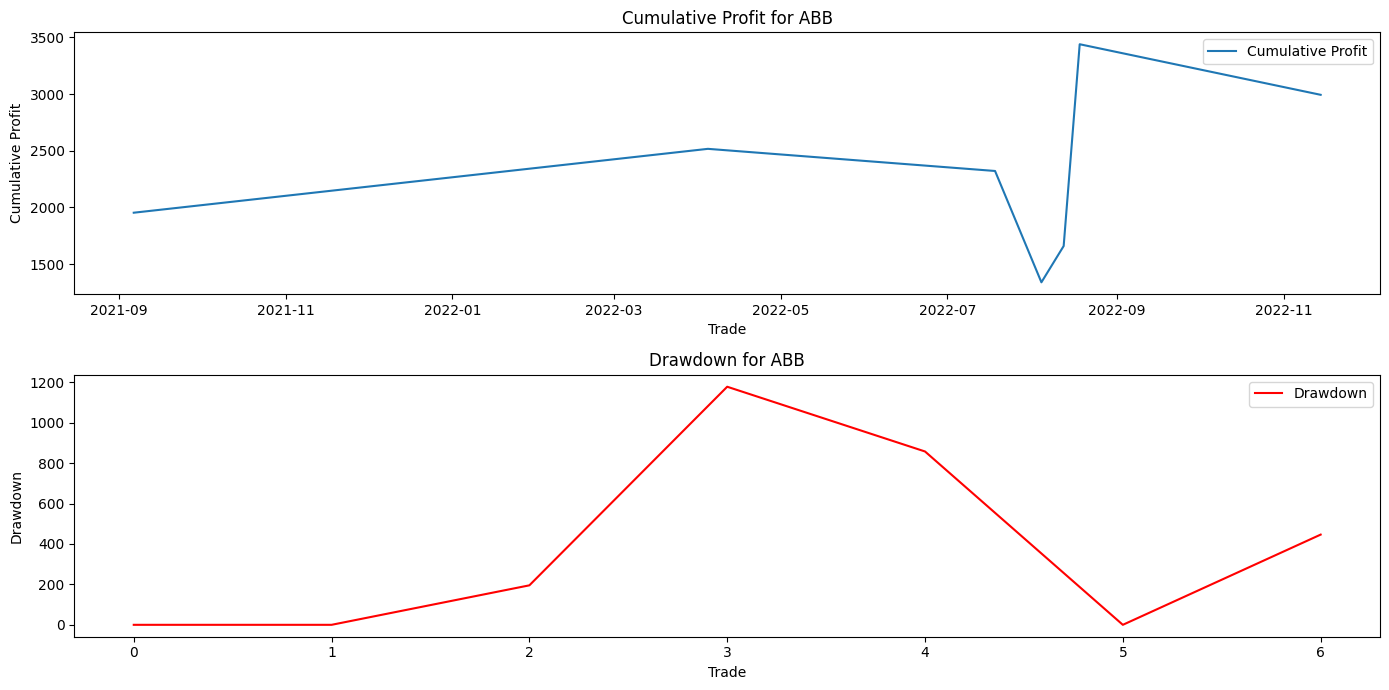

In [26]:
plot_metrics(trade_history_df, "ABB")

In [27]:
kpi

{'Total Trades': 7,
 'Winning Trades': 4,
 'Losing Trades': 3,
 'Win Rate': 0.5714285714285714,
 'Average PnL': 8.07857142857139,
 'Total Profit': 2993.199999999989,
 'Max Drawdown': 1177.6500000000106}

In [28]:
trade_history_df.loc[trade_history_df['Realized Profit'].idxmax()]

Buy Date             2021-09-06 10:15:00
Buy Price                         1586.0
Sell Date            2021-09-06 11:00:00
Sell Price                        1617.0
Type                                Long
Quantity                              63
Return                          0.019546
Days                                   0
PnL                                 31.0
Realized Profit                   1953.0
Cum Profit                        1953.0
Cumulative Return               0.019546
Drawdown                             0.0
Name: 0, dtype: object